# Assessment of Cosmic Ray Energy Estimation using Machine Learning

In [1]:
%matplotlib inline

import json
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

from utils import get_event_parameters, get_training_assessment_cut, get_cuts, r_log

## USER SETTINGS TO ADJUST

In [2]:
# Edit this file path to point to the models folder containing .h5 and .npy files for each model.
ICETOP_CNN_DATA_DIR = os.getenv['ICETOP_CNN_DATA_DIR']
MODELS_FOLDER_PATH = os.path.join(ICETOP_CNN_DATA_DIR, 'models')

# Edit this file path to point to the simdata folder containing the simulation data.
SIMDATA_FOLDER_PATH = os.path.join(ICETOP_CNN_DATA_DIR, 'simdata')

# Option to change font size for all labels within this notebook
LABEL_PARAMS = {
    'fontsize':20
}

# The keys will be the names of the models you wish to analyze
# The values will be the nuclei to assess for each model
MODEL_NAMES_AND_NUCLEI = {
    'honor': 'phof',
    'valor': 'phof'
}

In [3]:
# List available models

# Ensure that models folder has actually been found
assert os.path.exists(MODELS_FOLDER_PATH), f'ERROR: Could not find models folder. Path specified: {MODELS_FOLDER_PATH}'

model_list = glob(os.path.join(ICETOP_CNN_DATA_DIR, 'reconstructions', 'energy', '*.npy'))                     # Get all model .npy files
model_list = [os.path.splitext(os.path.basename(m))[0] for m in model_list]     # Trim parent directories and file extension

param_list = glob(os.path.join(MODELS_FOLDER_PATH, '*', '*.json'))                   # Get all parameter .json files
param_list = [os.path.splitext(os.path.basename(p))[0] for p in param_list]     # Trim parent directories and file extension

print('Available models:', sorted(set(model_list).intersection(param_list)))                  # Models that have both .npy and .json files
print('\nModels without parameter files:', sorted(set(model_list).difference(param_list)))    # Models that have a .npy file but no .json file

Available models: ['honor', 'valor']

Models without parameter files: []


In [4]:
# Automatic intake of parameters from parameter files
# Builds a dictionary mapping model names to their corresponding PREP dictionary
model_parameters = {}

for model_name, assessment_nuclei in MODEL_NAMES_AND_NUCLEI.items():
    # Construct the full .npy model path
    model_path = os.path.join(MODELS_FOLDER_PATH, model_name, model_name + '.json')

    # Ensure that the model is found (no typos)
    if not os.path.exists(model_path):
        print(f'WARNING: Model {model_name} not found at {MODELS_FOLDER_PATH}')
        continue

    # Load model parameters and save into dictionary along with assessment nuclei
    with open(model_path, 'r') as f:
        model_parameters[model_name] = json.load(f)
    model_parameters[model_name].update({'assessment_nuclei': assessment_nuclei})
    
    # Print entry
    print(model_name, ':', model_parameters[model_name])

assert len(model_parameters), 'ERROR: No models selected for analysis!'

honor : {'infill': False, 'clc': True, 'sta5': False, 'q': None, 't': None, 't_shift': True, 't_clip': 0.0, 'normed': True, 'reco': 'plane', 'training_nuclei': 'phof', 'assessment_nuclei': 'phof'}
valor : {'infill': False, 'clc': True, 'sta5': False, 'q': None, 't': None, 't_shift': True, 't_clip': 0.0, 'normed': True, 'reco': 'plane', 'training_nuclei': 'phof', 'assessment_nuclei': 'phof'}


In [5]:
# Load detector inputs and event parameters
# In its own cell because this can take a while
event_parameters = get_event_parameters(SIMDATA_FOLDER_PATH, composition='phof')

In [6]:
reconstructions = {}
cuts = {}

comp_conversion = {'p':1, 'h':4, 'o':16, 'f':56}

# Calculate reconstructed energies. This can take a bit (a few minutes), but should print out info on each model as it works
for model_name, model_prep in model_parameters.items():
    
    # Print model parameters as the different models predict
    print(f'Working on {model_name}...\n{model_prep}\n')

    # Load model prediction
    reconstruction = np.load(os.path.join(ICETOP_CNN_DATA_DIR, 'reconstructions', 'energy', model_name + '.npy')).flatten()
    
    # Load data cut
    cut = get_training_assessment_cut(event_parameters, 'assessment', model_prep)

    # Nuclei cut
    nuclei_to_assess = [comp_conversion[nuclei] for nuclei in model_prep['assessment_nuclei']]

    reconstruction = reconstruction[np.isin(event_parameters['comp'][cut], nuclei_to_assess)]
    cut *= np.isin(event_parameters['comp'], nuclei_to_assess)

    # Save data cut
    cuts[model_name] = cut
    
    # Save model prediction
    reconstructions[model_name] = reconstruction

Working on honor...
{'infill': False, 'clc': True, 'sta5': False, 'q': None, 't': None, 't_shift': True, 't_clip': 0.0, 'normed': True, 'reco': 'plane', 'training_nuclei': 'phof', 'assessment_nuclei': 'phof'}

(122789,)
1249702
1249702
122789
Working on valor...
{'infill': False, 'clc': True, 'sta5': False, 'q': None, 't': None, 't_shift': True, 't_clip': 0.0, 'normed': True, 'reco': 'plane', 'training_nuclei': 'phof', 'assessment_nuclei': 'phof'}

(122789,)
1249702
1249702
122789


In [14]:
for model_name, reconstructed_energy in reconstructions.items():
    log_difference = .1
    diffs = reconstructed_energy - event_parameters['energy'][cuts[model_name]]
    uncontained_diffs = reconstructed_energy[event_parameters['uncontained_cut'][cuts[model_name]]] - event_parameters['energy'][cuts[model_name] * event_parameters['uncontained_cut']]
    quality_diffs = reconstructed_energy[event_parameters['quality_cut'][cuts[model_name]]] - event_parameters['energy'][cuts[model_name] * event_parameters['quality_cut']]
    print(f'PERCENTAGE OF EVENTS RECONSTRUCTED WITHIN {log_difference} ORDER OF MAGNITUDE')
    print(f'Unfiltered events  | {(100 * len(list(filter(lambda x: abs(x) <= log_difference, diffs))) / len(diffs)):.2f}%')
    print(f'Uncontained events | {(100 * len(list(filter(lambda x: abs(x) <= log_difference, uncontained_diffs))) / len(uncontained_diffs)):.2f}%')
    print(f'Quality-cut events | {(100 * len(list(filter(lambda x: abs(x) <= log_difference, quality_diffs))) / len(quality_diffs)):.2f}%')

    reco_percent = 15
    percent_diffs = 100 * (r_log(reconstructed_energy) - r_log(event_parameters['energy'][cuts[model_name]])) / r_log(event_parameters['energy'][cuts[model_name]])
    uncontained_percent_diffs = 100 * (r_log(reconstructed_energy[event_parameters['uncontained_cut'][cuts[model_name]]]) - r_log(event_parameters['energy'][cuts[model_name] * event_parameters['uncontained_cut']])) / r_log(event_parameters['energy'][cuts[model_name] * event_parameters['uncontained_cut']])
    quality_percent_diffs = 100 * (r_log(reconstructed_energy[event_parameters['quality_cut'][cuts[model_name]]]) - r_log(event_parameters['energy'][cuts[model_name] * event_parameters['quality_cut']])) / r_log(event_parameters['energy'][cuts[model_name] * event_parameters['quality_cut']])
    print(f'PERCENTAGE OF EVENTS RECONSTRUCTED WITHIN {reco_percent}% OF THEIR TRUE ENERGIES')
    print(f'Unfiltered events  | {(100 * len(list(filter(lambda x: abs(x) <= reco_percent, percent_diffs))) / len(percent_diffs)):.2f}%')
    print(f'Uncontained events | {(100 * len(list(filter(lambda x: abs(x) <= reco_percent, uncontained_percent_diffs))) / len(uncontained_percent_diffs)):.2f}%')
    print(f'Quality-cut events | {(100 * len(list(filter(lambda x: abs(x) <= reco_percent, quality_percent_diffs))) / len(quality_percent_diffs)):.2f}%')
    print()


PERCENTAGE OF EVENTS RECONSTRUCTED WITHIN 0.1 ORDER OF MAGNITUDE
Unfiltered events  | 55.37%
Uncontained events | 48.77%
Quality-cut events | 73.64%
PERCENTAGE OF EVENTS RECONSTRUCTED WITHIN 15% OF THEIR TRUE ENERGIES
Unfiltered events  | 38.69%
Uncontained events | 33.50%
Quality-cut events | 53.51%

PERCENTAGE OF EVENTS RECONSTRUCTED WITHIN 0.1 ORDER OF MAGNITUDE
Unfiltered events  | 63.75%
Uncontained events | 57.38%
Quality-cut events | 82.55%
PERCENTAGE OF EVENTS RECONSTRUCTED WITHIN 15% OF THEIR TRUE ENERGIES
Unfiltered events  | 47.47%
Uncontained events | 41.17%
Quality-cut events | 66.69%



In [8]:
ebins = np.linspace(5, 8, 181)
evalues = (ebins[:-1] + ebins[1:]) / 2

cut_names = ['No Cut', 'Quality Cut']
ncols, nrows = len(cut_names), len(MODEL_NAMES_AND_NUCLEI.keys())

### Logged Energy Resolution

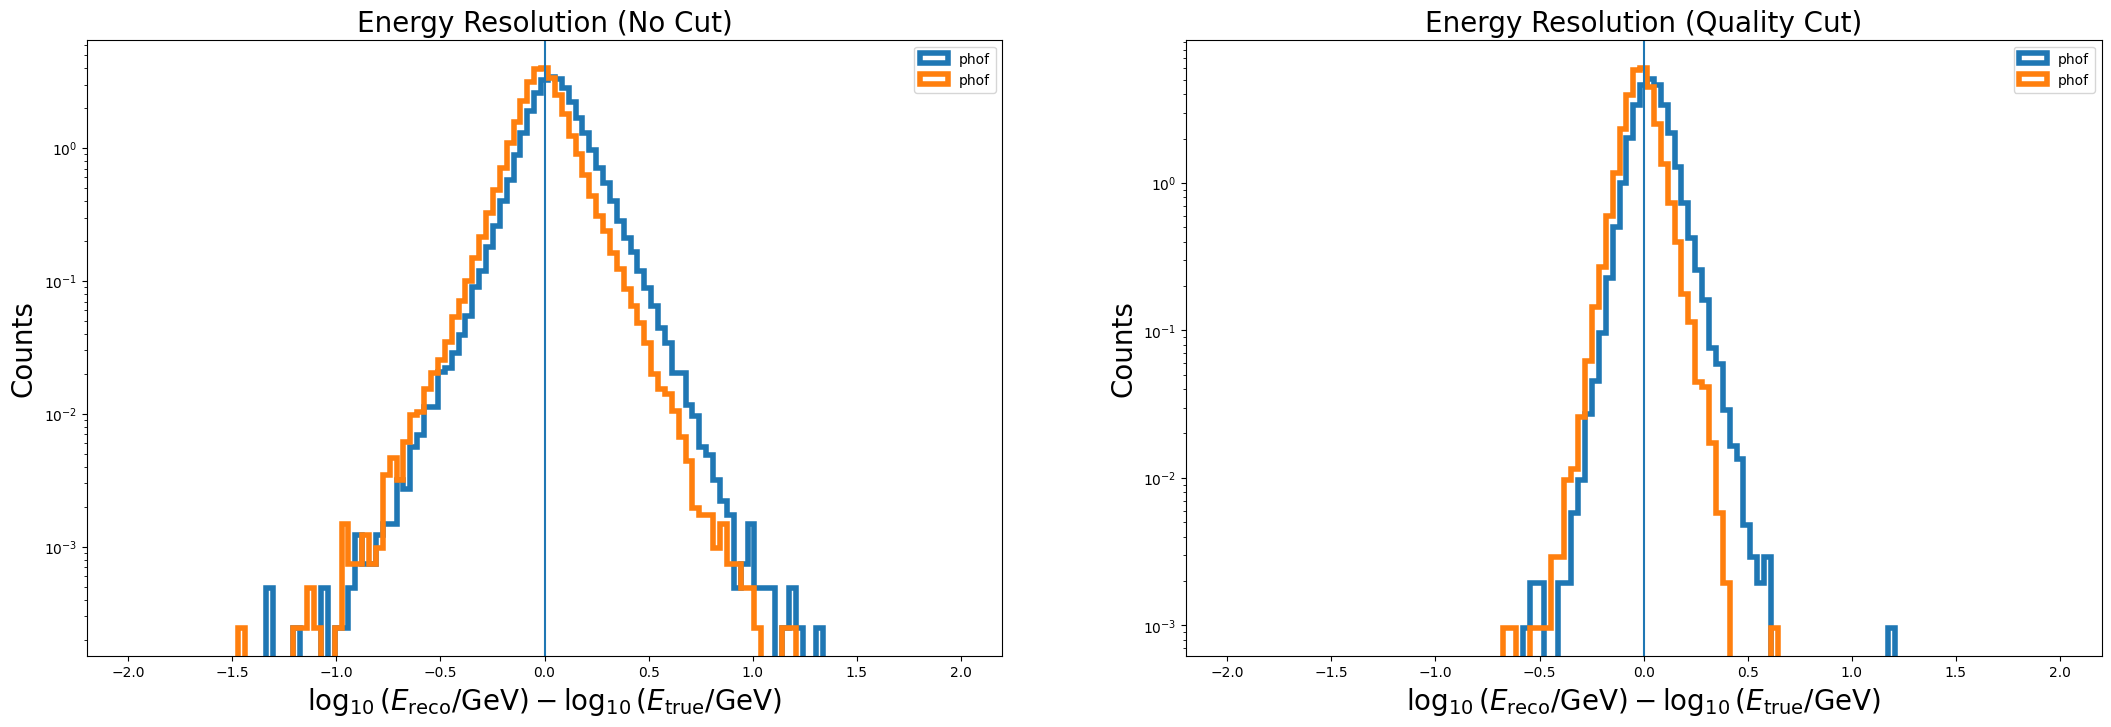

In [9]:
# Plot logged energy resolution

hist_args = {'range':(-2,2), 'bins':121, 'density': True, 'histtype':'step', 'log':True, 'linewidth':4}
fig, axs = plt.subplots(figsize=(13*ncols, 8), ncols=ncols)

for i, cut_name in enumerate(cut_names):
    for model_name, model_description in MODEL_NAMES_AND_NUCLEI.items():
        reconstructions_cut, energy_cut = get_cuts(cuts[model_name], event_parameters, cut_name)
        axs[i].hist((reconstructions[model_name][reconstructions_cut] - event_parameters['energy'][energy_cut]), label=model_description, **hist_args)
    axs[i].set_title(f'Energy Resolution ({cut_name})', **LABEL_PARAMS)
    axs[i].set_xlabel(r'$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV}) - \log_{10}(E_{\mathrm{true}}/\mathrm{GeV})$', **LABEL_PARAMS)
    axs[i].set_ylabel('Counts', **LABEL_PARAMS)
    axs[i].legend()
    axs[i].axvline()

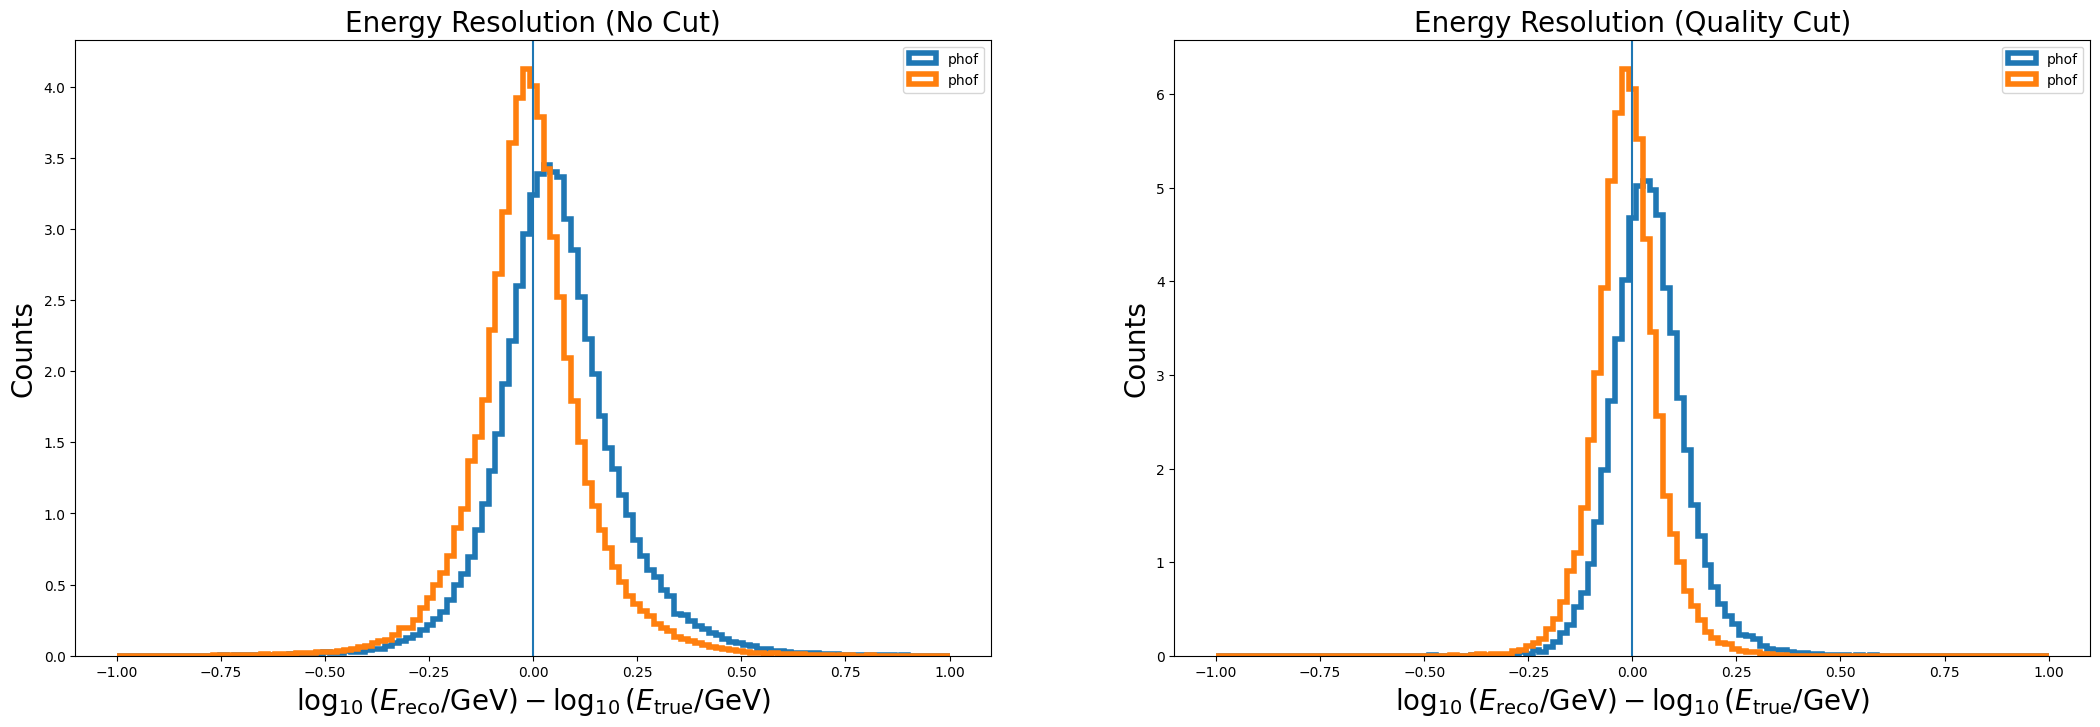

In [10]:
# Plot zoomed and unlogged energy resolution

hist_args = {'range':(-1,1), 'bins':121, 'density':True, 'histtype':'step', 'log':False, 'linewidth':4}
fig, axs = plt.subplots(figsize=(13*ncols, 8), ncols=ncols)

for i, cut_name in enumerate(cut_names):
    for model_name, model_description in MODEL_NAMES_AND_NUCLEI.items():
        reconstructions_cut, energy_cut = get_cuts(cuts[model_name], event_parameters, cut_name)
        axs[i].hist((reconstructions[model_name][reconstructions_cut] - event_parameters['energy'][energy_cut]), label=model_description, **hist_args)
    axs[i].set_title(f'Energy Resolution ({cut_name})', **LABEL_PARAMS)
    axs[i].set_xlabel(r'$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV}) - \log_{10}(E_{\mathrm{true}}/\mathrm{GeV})$', **LABEL_PARAMS)
    axs[i].set_ylabel('Counts', **LABEL_PARAMS)
    axs[i].legend()
    axs[i].axvline()

### Summary Parameters

In [11]:
for model_name in MODEL_NAMES_AND_NUCLEI.keys():
    for cut_name in cut_names:
        reconstructions_cut, energy_cut = get_cuts(cuts[model_name], event_parameters, cut_name)
        median, err_min, err_max = np.percentile(reconstructions[model_name][reconstructions_cut] - event_parameters['energy'][energy_cut], (50,16,84))
        print(f'Energy resolution for {model_name} ({cut_name}): {median:.3f} +{err_max:.3f} {err_min:.3f}')
    print()

Energy resolution for honor (No Cut): 0.049 +0.186 -0.067
Energy resolution for honor (Quality Cut): 0.037 +0.120 -0.040

Energy resolution for valor (No Cut): -0.009 +0.105 -0.117
Energy resolution for valor (Quality Cut): -0.013 +0.055 -0.080



### Two-Dimensional Visualization

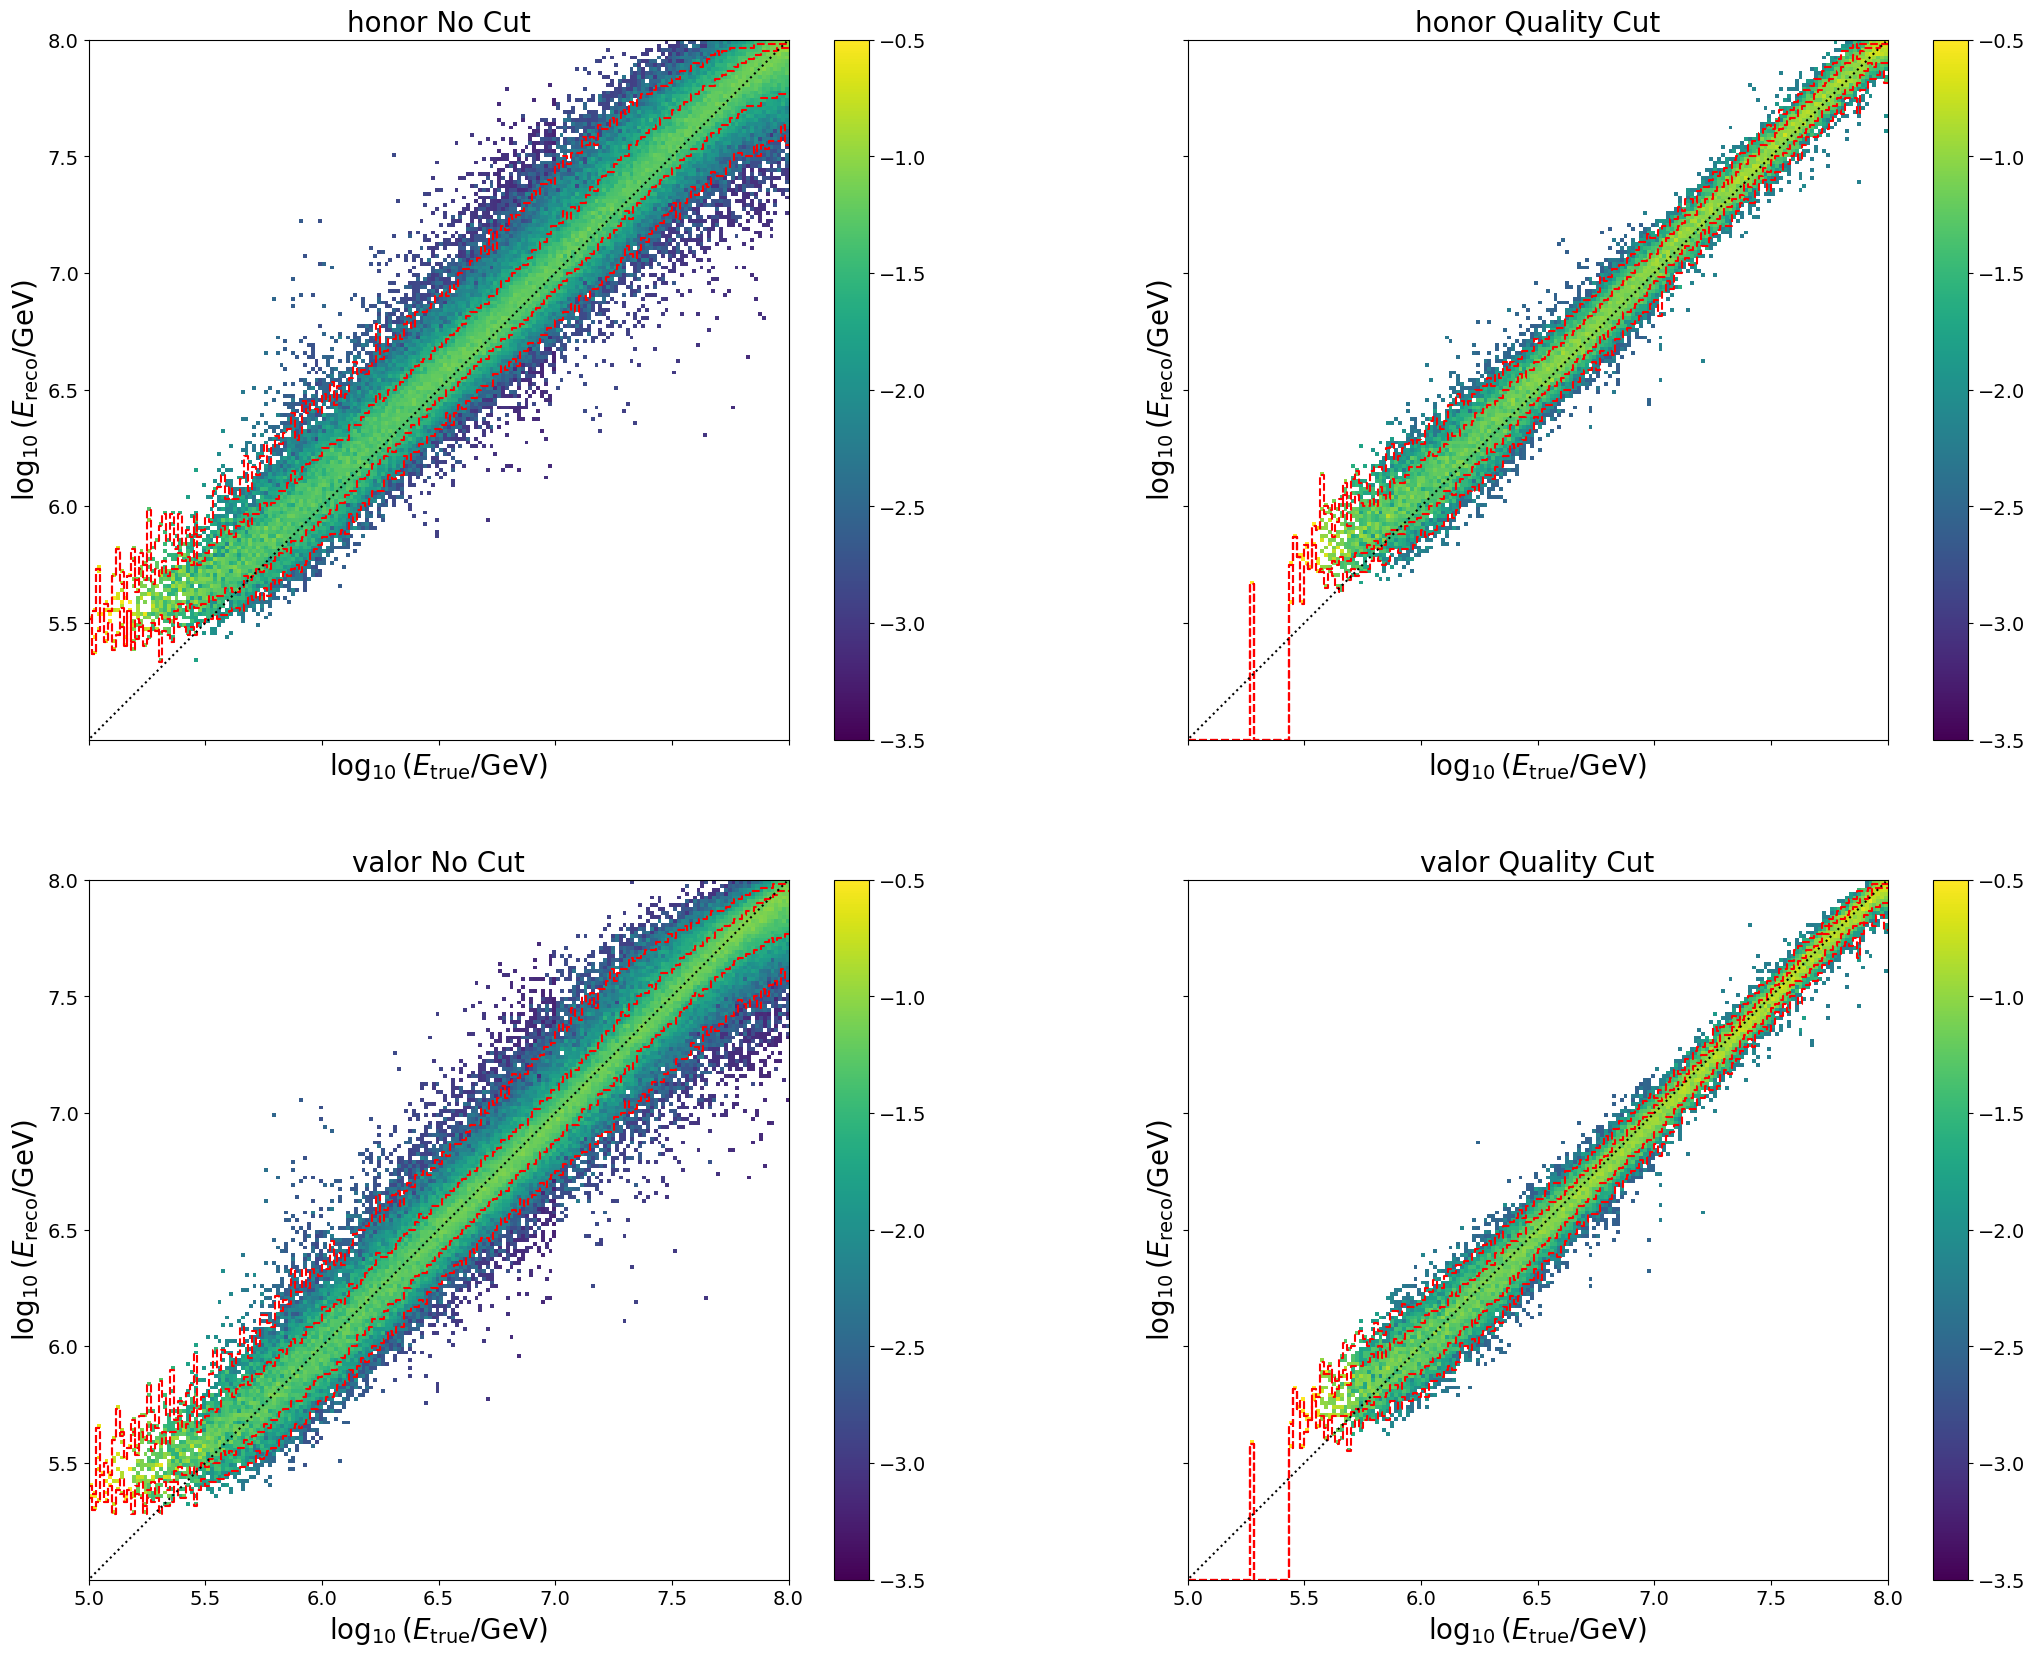

In [12]:
np.seterr(divide = 'ignore')

fig, axs = plt.subplots(figsize=(13*ncols, 10*nrows), ncols=ncols, nrows=nrows,
                        sharex=True, sharey=True)

for i, model_name in enumerate(MODEL_NAMES_AND_NUCLEI.keys()):
    for j, cut_name in enumerate(cut_names):
        
        ax = axs[i, j] if nrows > 1 else axs[j]
        ax.tick_params(axis='both', direction='out', labelsize=14)
        reconstructions_cut, energy_cut = get_cuts(cuts[model_name], event_parameters, cut_name)
        
        h, xedges, yedges = np.histogram2d(reconstructions[model_name][reconstructions_cut], event_parameters['energy'][energy_cut], bins=(ebins, ebins), density=False, weights=None)
        
        # Normalize
        ntot = np.sum(h, axis=0).astype(float)
        ntot[ntot==0] = 1.
        h /= ntot
        
        # Create contours
        contour_values = [0.025, 0.16, 0.84, 0.975]
        contour_list = [[] for _ in contour_values]
        for c, col in enumerate(h.transpose()):
            ccol = col.cumsum()
            for l, val in zip(contour_list, contour_values):
                try: l += [np.where(ccol > val)[0][0]]
                except IndexError:
                    l += [0]
        for l in contour_list:
            l.insert(0, l[0])
            if i >= len(contour_list) / 2:
                l = [j+1 for j in l]
            ax.step(ebins, ebins[l], color='red', linestyle='--')
        
        ax.plot(evalues, evalues, 'k', ls=':')
        
        # Plot on a log scale
        extent = [yedges[0], yedges[-1], xedges[0], xedges[-1]]
        im = ax.imshow(np.log10(h), extent=extent, origin='lower', interpolation='none', vmin=-3.5, vmax=-0.5)
        ax.set_title(f'{model_name} {cut_name}', **LABEL_PARAMS)
        ax.set_xlabel(r'$\log_{10}(E_{\mathrm{true}}/\mathrm{GeV})$', **LABEL_PARAMS)
        ax.set_ylabel(r'$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$', **LABEL_PARAMS)
        #ax.tick_params(labelsize=24)
        ax.set_yticks(np.linspace(5.5, 8, num=6))
        #im.ax.tick_params(labelsize=20) 
        cbar = fig.colorbar(im, ax=ax)
        cbar.ax.tick_params(labelsize=14)

### Energy Resolution as a Function of Zenith

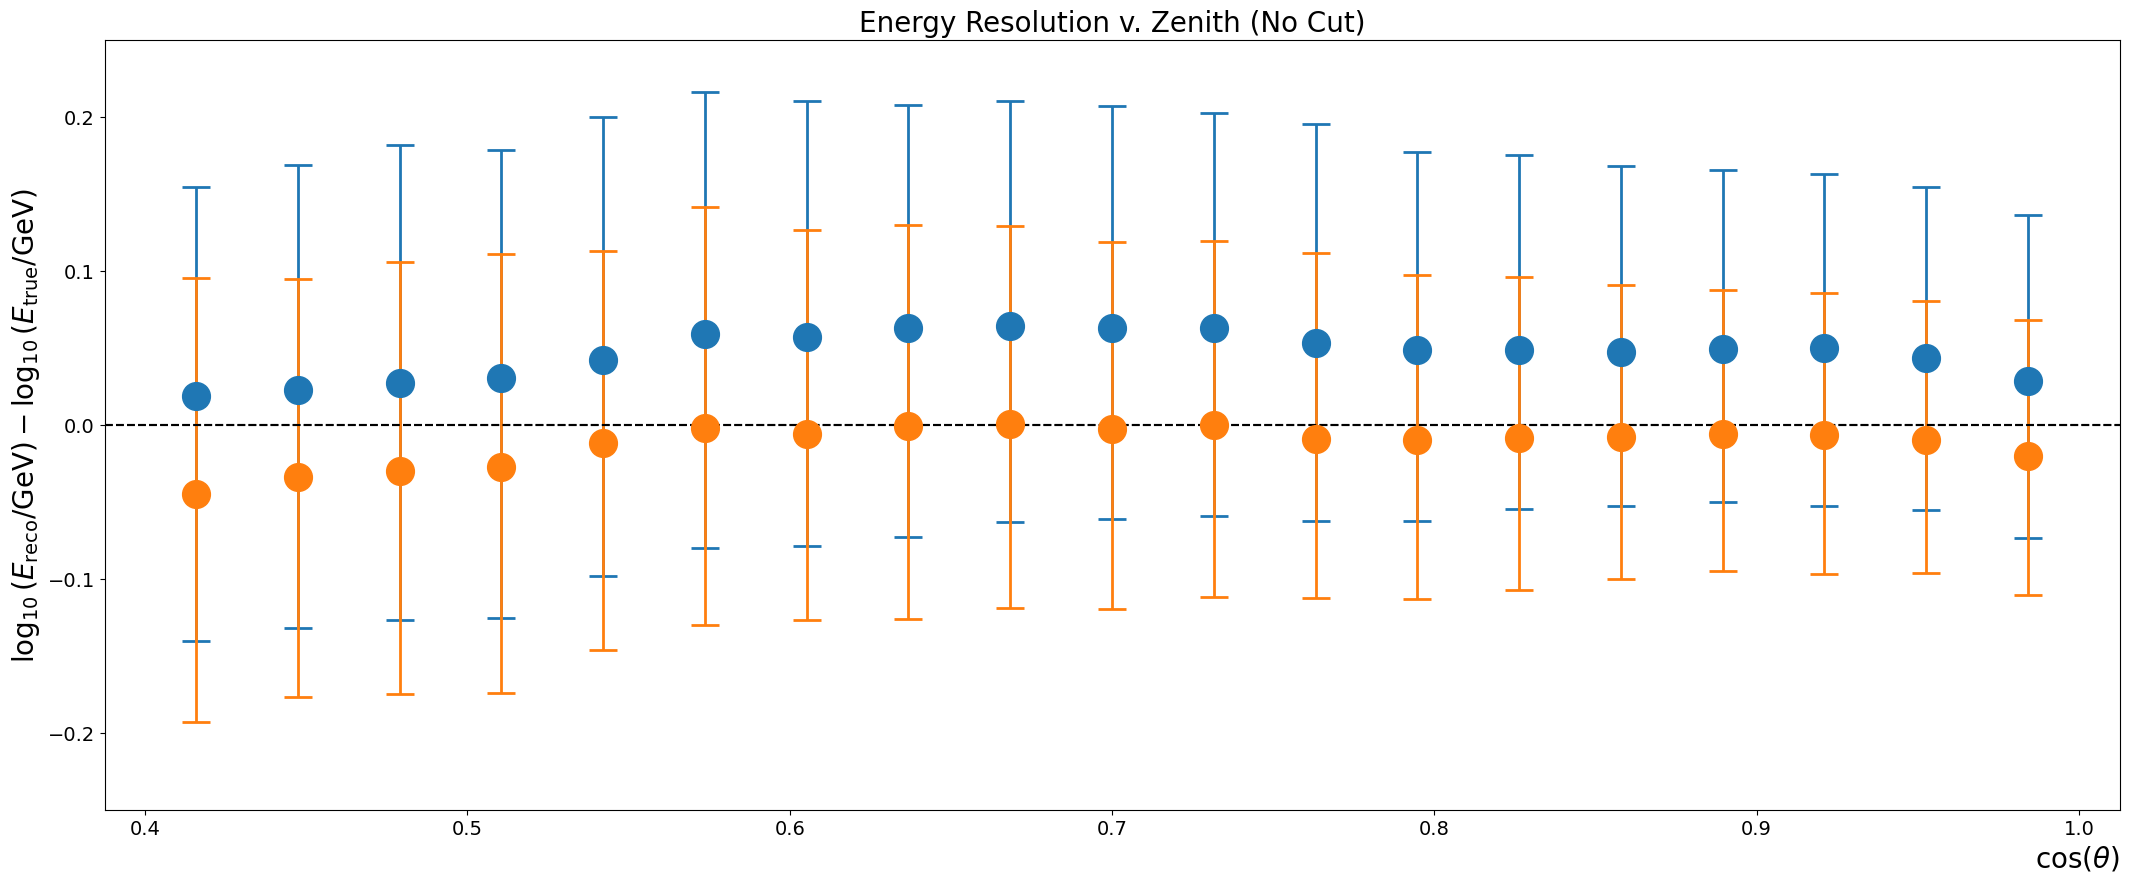

In [13]:
coszbins = np.linspace(0.4,1,20)
coszvalues = (coszbins[1:]+coszbins[:-1])/2
kwargs = {'fmt':'.',
          'markersize':40,
          'elinewidth':2,
          'capsize':10,
          'capthick':2}

fig, axs = plt.subplots(figsize=(26, 10), ncols=1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

for k, model_name in enumerate(MODEL_NAMES_AND_NUCLEI.keys()):
    
    theta = np.pi - event_parameters['laputop_dir'].transpose()[0].astype('float64')[cuts[model_name]]

    array_info = np.zeros(shape=(len(coszvalues), 3))
    reconstructions_cut, energy_cut = get_cuts(cuts[model_name], event_parameters, 'No Cut')
    binned_zenith = np.digitize(np.cos(theta)[reconstructions_cut], coszbins) - 1
    for j in range(len(coszvalues)):
        coszcut = (binned_zenith == j)
        temp_events = reconstructions[model_name][reconstructions_cut][coszcut]
        if len(temp_events) != 0:
            array_info[j] = np.percentile(temp_events - event_parameters['energy'][energy_cut][coszcut], (50, 16, 84))

    median, err_min, err_max = np.transpose(array_info)
    axs.errorbar(coszvalues, median, yerr=(median-err_min, err_max-median), label=model_name, **kwargs)
    
    axs.axhline(color='k', ls='--')
    axs.set_title('Energy Resolution v. Zenith (No Cut)', **LABEL_PARAMS)
    axs.set_xlabel(r'$\cos(\theta)$', loc='right', **LABEL_PARAMS)
    axs.set_ylabel(r'$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV}) - \log_{10}(E_{\mathrm{true}}/\mathrm{GeV})$', **LABEL_PARAMS)
    axs.set_ylim(-0.25, 0.25)
    #axs.legend()